# Import des modules


In [118]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import spearmanr
from collections import Counter
from sklearn.pipeline import Pipeline

#Preprocess
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler, MultiLabelBinarizer, OrdinalEncoder

In [119]:
fc = pd.read_csv('fc.csv')

# matrice de corrélation de Pearson

 - Eliminer les fortes corrélations linéaires entre features.
    - revenu_mensuel / niveau_hierarchique_poste

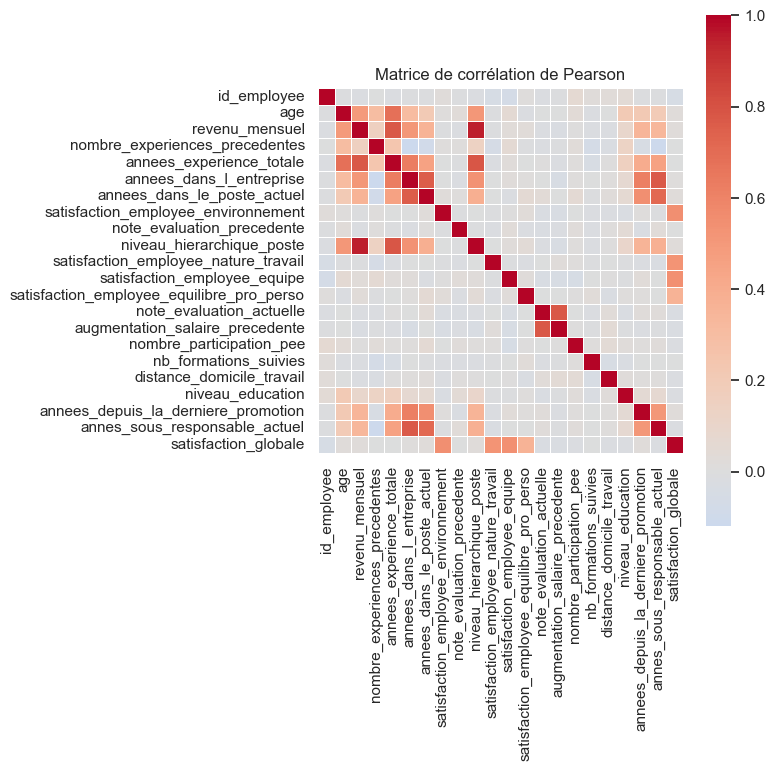

In [120]:
# Sélectionner uniquement les colonnes numériques pour l'analyse de corrélation
numeric_cols = fc.select_dtypes(include=[np.number])
# Calculer la matrice de corrélation entre toutes les variables numériques
corrmat = numeric_cols.corr()
# Créer une figure de taille appropriée pour visualiser toutes les corrélations
f, ax = plt.subplots(figsize=(8, 8))
# Générer la heatmap de corrélation
sns.heatmap(corrmat,
            cmap='coolwarm',  # Palette de couleurs adaptée aux corrélations (bleu=négatif, rouge=positif)
            center=0,  # Centrer la palette de couleurs sur 0
            square=True,  # Cellules carrées pour un meilleur rendu visuel
            linewidths=0.5)  # Ajouter des lignes de séparation entre les cellules

plt.title('Matrice de corrélation de Pearson')
plt.tight_layout()  # Ajuster automatiquement la mise en page
plt.show()


# méthode d’encoding adaptée pour les features qualitatives


In [121]:

# BOOLEAN
fc["heure_supplementaires"] = fc["heure_supplementaires"].map({"Oui":True, "Non":False}).astype(bool)
fc["a_quitte_l_entreprise"] = fc["a_quitte_l_entreprise"].map({"Oui":True, "Non":False}).astype(bool)
fc["genre"] = fc["genre"].map({"M":True, "F":False}).astype(bool)

# LABEL ENCODER
#le = LabelEncoder()
#fc['frequence_deplacement'] = le.fit_transform(fc["frequence_deplacement"])
#print("Category Mapping:", le.classes_)

col_onehot = ["poste", "domaine_etude"]
col_ordinal = ["frequence_deplacement", "statut_marital"]
#col_num = ["revenu_mensuel", "age"]

# Définition du préprocesseur
preprocessor = ColumnTransformer(
    transformers=[
        ("onehot", OneHotEncoder(drop="first"), col_onehot),
        ("ordinal", OrdinalEncoder(), col_ordinal)#,
        #("num", StandardScaler(), col_num)
    ],
    remainder='passthrough'  # Garde les autres colonnes
)

# Pipeline (ici juste le prétraitement, mais tu peux ajouter un modèle après)
pipeline = Pipeline(steps=[("preprocessor", preprocessor)])

# Application
X_transformed = pipeline.fit_transform(fc)

# --- Récupérer les noms de colonnes ---
ohe = pipeline.named_steps["preprocessor"].named_transformers_["onehot"]
onehot_cols = ohe.get_feature_names_out(col_onehot)

all_columns = list(onehot_cols) + col_ordinal #+ col_num

# Ajouter les colonnes "passthrough" (celles non transformées)
remaining_cols = [col for col in fc.columns if col not in col_onehot + col_ordinal]
all_columns += remaining_cols

# --- Refaire un DataFrame propre ---
fc_transformed = pd.DataFrame(
    X_transformed,
    columns=all_columns,
    index=fc.index
)
fc_transformed.info()

fc = fc_transformed

fc = fc_transformed.sort_index(axis=1)
fc.info()

#fc = fc.merge(fc_transformed, left_index=True, right_index=True)
#fc.drop((['id_employee','age_x','revenu_mensuel_x','statut_marital_x','poste','domaine_etude','frequence_deplacement_x']), axis=1, inplace=True)
#fc.columns = fc.columns.str.replace("_y", "", regex=False)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1470 entries, 0 to 1469
Data columns (total 40 columns):
 #   Column                                     Non-Null Count  Dtype 
---  ------                                     --------------  ----- 
 0   poste_Cadre Commercial                     1470 non-null   object
 1   poste_Consultant                           1470 non-null   object
 2   poste_Directeur Technique                  1470 non-null   object
 3   poste_Manager                              1470 non-null   object
 4   poste_Representant Commercial              1470 non-null   object
 5   poste_Ressources Humaines                  1470 non-null   object
 6   poste_Senior Manager                       1470 non-null   object
 7   poste_Tech Lead                            1470 non-null   object
 8   domaine_etude_Entrepreunariat              1470 non-null   object
 9   domaine_etude_Infra & Cloud                1470 non-null   object
 10  domaine_etude_Marketing             

# matrice de corrélation de Spearman

- Tracer un pairplot pour mesurer l’intensité des corrélations non-linéaires

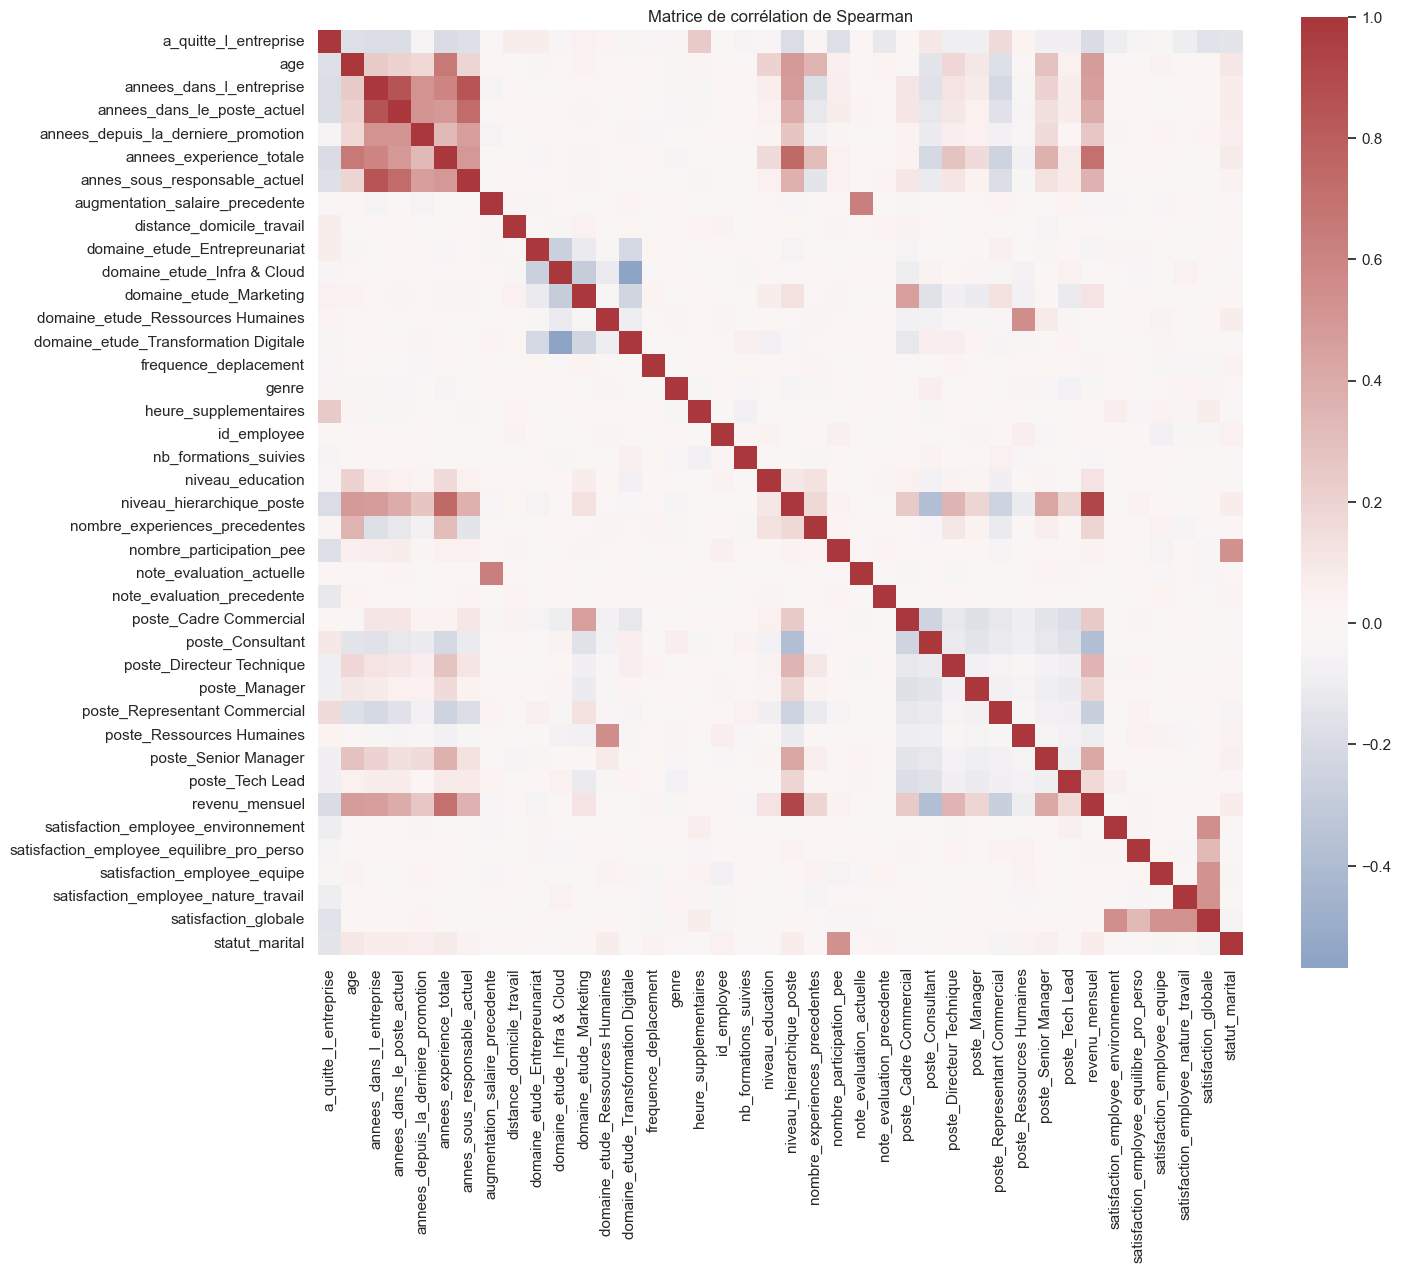

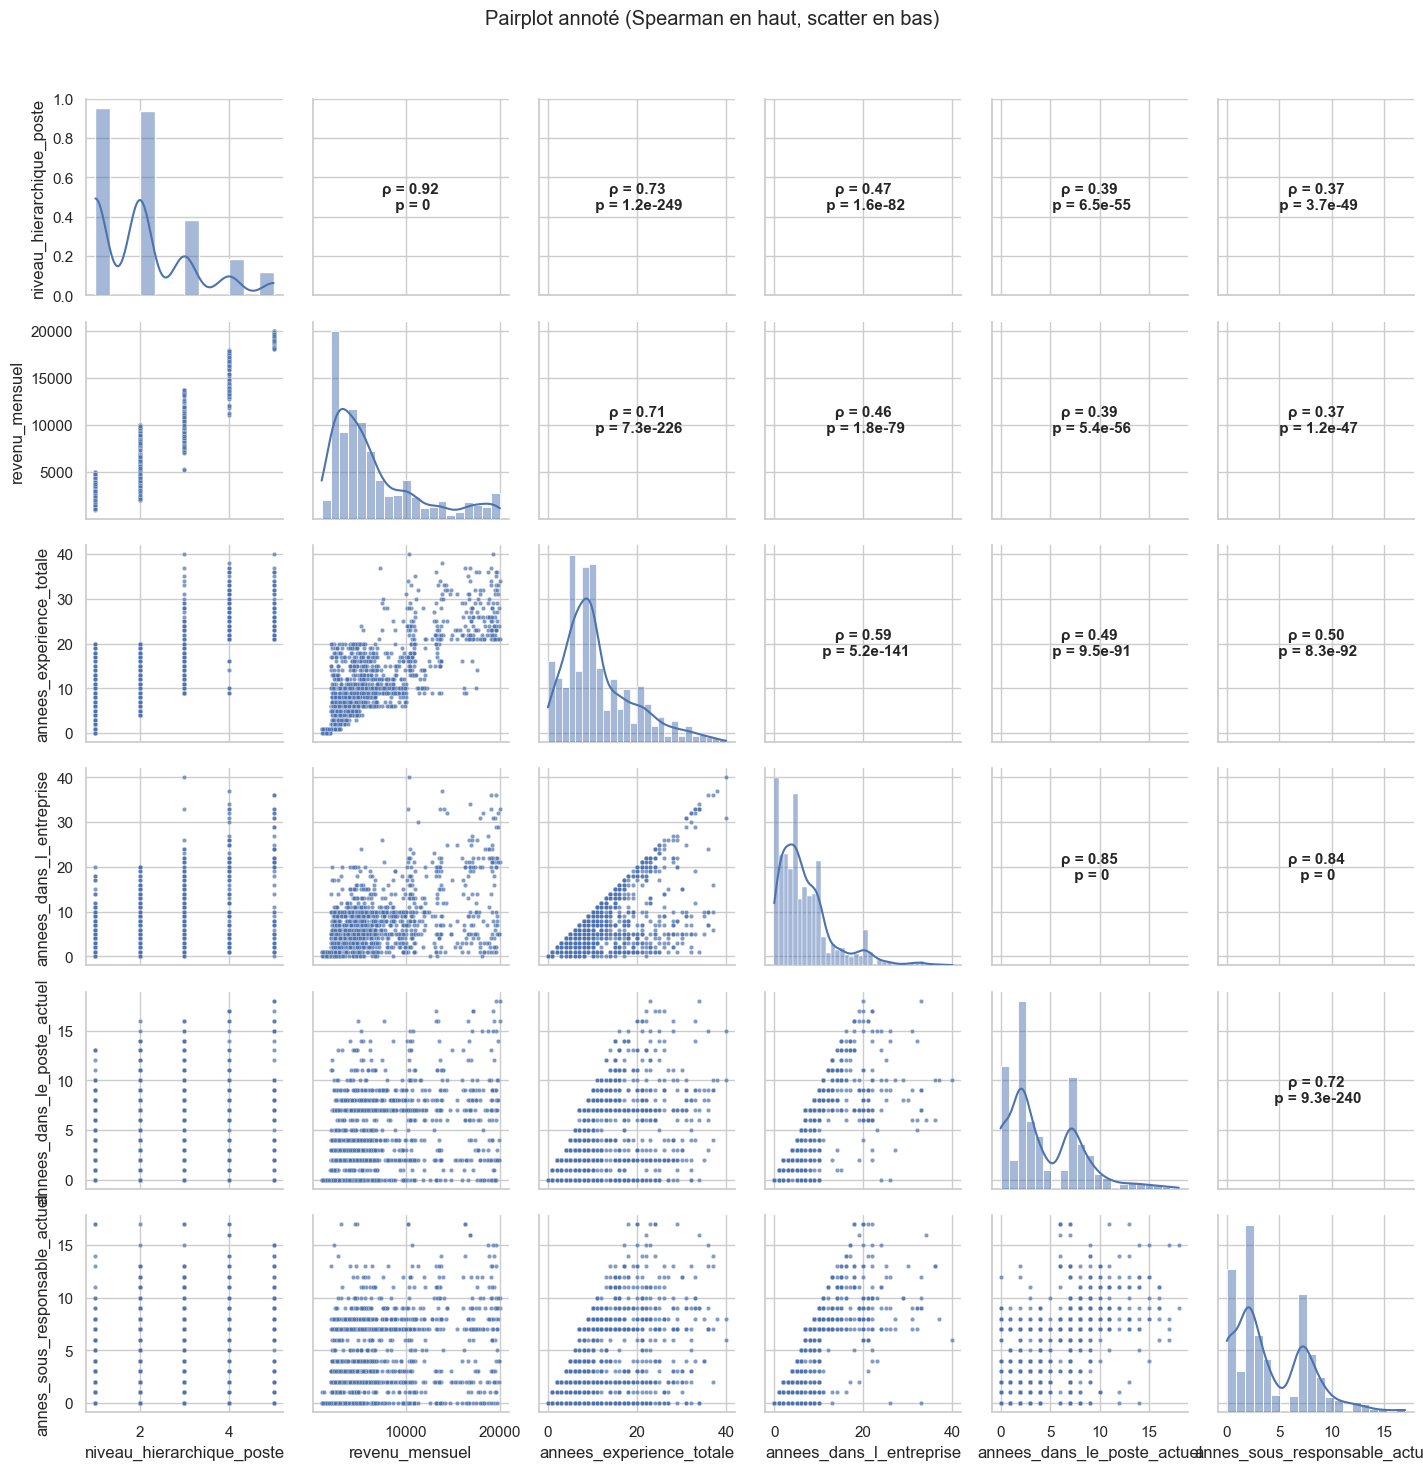

In [122]:
sns.set(style="whitegrid")

# --- 1) Matrice de corrélation de Spearman (valeurs + p-values optionnelles) ---
spearman_corr = fc.corr(method="spearman")  # matrice simple des coefficients
# si on veut p-values :
def spearman_matrix_with_pvals(data):
    cols = data.columns
    n = len(cols)
    corr = pd.DataFrame(np.zeros((n,n)), index=cols, columns=cols)
    pval = pd.DataFrame(np.zeros((n,n)), index=cols, columns=cols)
    for i, a in enumerate(cols):
        for j, b in enumerate(cols):
            if i <= j:
                r, p = spearmanr(data[a], data[b], nan_policy='omit')
                corr.loc[a,b] = corr.loc[b,a] = r
                pval.loc[a,b] = pval.loc[b,a] = p
    return corr, pval

corr, pvals = spearman_matrix_with_pvals(fc)

# Heatmap annotée (Spearman)
plt.figure(figsize=(15,15))
sns.heatmap(corr, annot=False, fmt=".2f", cmap="vlag", center=0, square=True,
            cbar_kws={"shrink":0.75})
plt.title("Matrice de corrélation de Spearman")
plt.tight_layout()
plt.show()


# --- 2) PairGrid avec scatter en bas et annotation du coefficient Spearman en haut ---
def annotate_spearman(x, y, **kws):
    r, p = spearmanr(x, y, nan_policy='omit')
    ax = plt.gca()
    text = f"ρ = {r:.2f}\n p = {p:.2g}"
    # placer le texte centré
    ax.annotate(text, xy=(0.5, 0.5), xycoords='axes fraction',
                ha='center', va='center', fontsize=11, weight='bold')

# 1️⃣ Calcul de la corrélation (Spearman)
corr = fc.corr(method='spearman').abs()

# 2️⃣ Sélectionner les k colonnes les plus corrélées avec la cible (ou globalement)
# Ici, on prend les k colonnes les plus corrélées entre elles (excluant la diagonale)
k = 6
# Somme des corrélations pour chaque colonne (minus self-correlation)
col_corr_sum = corr.sum() - 1  # on retire la diagonale
top_cols = col_corr_sum.sort_values(ascending=False).head(k).index.tolist()

g = sns.PairGrid(fc[top_cols], diag_sharey=False, corner=False, height=2.4)

# lower : scatter (ou scatter + lowess si utile)
g.map_lower(sns.scatterplot, s=10, alpha=0.7)

# upper : afficher le coeff de Spearman
g.map_upper(annotate_spearman)

# diag : histogrammes
g.map_diag(sns.histplot, kde=True)

plt.suptitle("Pairplot annoté (Spearman en haut, scatter en bas)", y=1.02)
plt.tight_layout()
plt.show()


# --- Conseils supplémentaires ---
# 1) Si tu veux détecter corrélations non-monotones (ex: U-shape), Spearman peut rater;
#    envisager d'autres mesures (MIC, distance correlation, mutual information).
# 2) Pour mettre en évidence une tendance non-linéaire monotone dans les nuages de points,
#    tu peux remplacer map_lower(sns.scatterplot) par sns.regplot(..., lowess=True) sur chaque paire.
# 3) Pour de grandes dimensions (>10), le pairplot devient illisible : préférer heatmap + méthodes de réduction de dimension (PCA, t-SNE, UMAP).

# Export CSV

In [123]:
# Suppression des lignes "True" dans la colonne "a_quitte_l_entreprise"
#print(f"Nombre total de salaries: {len(fc)}")
#fc = fc.loc[fc['a_quitte_l_entreprise'] == False]
#print(f"Nombre total de salaries non demissionaire: {len(fc)}")

fc.to_csv('fc_after_feature_engineering.csv', index=False)